# Model Building and Evaluation

This notebook focuses on building and comparing machine learning models for a movie recommendation system using the MovieLens dataset.

The objective is to implement at least three approaches:
1. A non-personalized baseline model.
2. Content-based machine learning models that use movie features only.
3. Evaluation of each model using appropriate metrics.


In [1]:
import pandas as pd
import numpy as np

ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")
tags = pd.read_csv("tags.csv")


ratings.shape, movies.shape, tags.shape

# 2. Sample Ratings
SAMPLE_SIZE = 500_000
ratings = ratings.sample(n=min(SAMPLE_SIZE, len(ratings)), random_state=42).copy()

# 3. Filter Movies and Tags based on Sampled Ratings
rated_movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(rated_movie_ids)].copy()
tags = tags[tags['movieId'].isin(rated_movie_ids)].copy()

# 4. Summary Report
print(f"{' DATA REDUCTION SUMMARY ':=^40}")
print(f"Ratings: {len(ratings):,}")
print(f"Movies:  {len(movies):,}")
print(f"Tags:    {len(tags):,}")
print(f"Est. Training: ~{len(ratings)/100000*2:.0f} mins")
print(f"{'='*40}")


======== DATA REDUCTION SUMMARY ========
Ratings: 500,000
Movies:  20,783
Tags:    2,058,516
Est. Training: ~10 mins


## Modeling Overview

Three approaches are implemented:

1. A non-personalized baseline using a weighted popularity score.
2. A content-based regression model that predicts movie ratings.
3. A content-based binary model that predicts whether a user will like a movie.

All content-based models use movie features only.


## Model 1: Non-Personalized Baseline (Weighted Popularity)

This model recommends the same Top-N movies to all users.
It combines the average rating and the number of ratings using a weighted formula.
This approach is similar to the IMDb weighted rating system.


In [2]:
movie_stats = ratings.groupby("movieId").agg(
    rating_count=("rating", "count"),
    rating_mean=("rating", "mean")
).reset_index()

global_mean = ratings["rating"].mean()
min_votes = movie_stats["rating_count"].quantile(0.70)

movie_stats["weighted_score"] = (
    (movie_stats["rating_count"] / (movie_stats["rating_count"] + min_votes)) * movie_stats["rating_mean"]
    + (min_votes / (movie_stats["rating_count"] + min_votes)) * global_mean
)

top_movies = (
    movie_stats
    .merge(movies[["movieId", "title", "genres"]], on="movieId", how="left")
    .sort_values("weighted_score", ascending=False)
    .head(20)
)

top_movies[["title", "genres", "rating_count", "rating_mean", "weighted_score"]]


,title,genres,rating_count,rating_mean,weighted_score
300,"Shawshank Redemption, The (1994)",Crime|Drama,1854,4.403722,4.400036
16016,Planet Earth (2006),Documentary,41,4.560976,4.395264
48,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1076,4.320632,4.314915
16758,Band of Brothers (2001),Action|Drama|War,52,4.432692,4.314466
783,"Godfather, The (1972)",Crime|Drama,1065,4.317840,4.312086
1777,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama,257,4.276265,4.254219
18898,Parasite (2019),Comedy|Drama,192,4.276042,4.246840
507,Schindler's List (1993),Drama|War,1256,4.245223,4.240797
1101,"Godfather: Part II, The (1974)",Crime|Drama,695,4.243165,4.235232
8624,"Lives of Others, The (Das leben der Anderen) (...",Drama|Romance|Thriller,187,4.264706,4.235220


## Model 2: Content-Based Rating Prediction (Regression)

This model predicts the numeric rating of a movie using movie features only.
Genres and user-generated tags are converted into numerical features.

The model is evaluated using RMSE and MAE.


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack

movies_cb = movies.copy()

movies_cb["genres_text"] = (
    movies_cb["genres"]
    .fillna("")
    .str.replace("|", " ", regex=False)
    .str.lower()
)

tags_cb = tags.copy()
tags_cb["tag"] = (
    tags_cb["tag"]
    .astype(str)
    .str.lower()
    .str.strip()
)

movie_tags = (
    tags_cb.groupby("movieId")["tag"]
    .apply(lambda x: " ".join(x))
    .reset_index()
    .rename(columns={"tag": "tags_text"})
)

movies_cb = movies_cb.merge(movie_tags, on="movieId", how="left")
movies_cb["tags_text"] = movies_cb["tags_text"].fillna("")

movies_cb["content_text"] = (
    movies_cb["genres_text"] + " " + movies_cb["tags_text"]
).str.strip()

# Remove empty content rows (CRITICAL)
movies_cb = movies_cb[movies_cb["content_text"] != ""]

tfidf = TfidfVectorizer(
    max_features=20000,
    min_df=1,
    stop_words="english"
)

X_movies = tfidf.fit_transform(movies_cb["content_text"])

print("TF-IDF matrix shape:", X_movies.shape)
print("Vocabulary size:", len(tfidf.vocabulary_))


movie_id_to_index = pd.Series(
    movies_cb.index, index=movies_cb["movieId"]
).to_dict()

ratings_ml = ratings[ratings["movieId"].isin(movie_id_to_index.keys())].copy()
ratings_ml["row_idx"] = ratings_ml["movieId"].map(movie_id_to_index)

print("Ratings before dropna:", len(ratings_ml))
ratings_ml = ratings_ml.dropna(subset=["row_idx"])
print("Ratings after dropna:", len(ratings_ml))

row_idx = ratings_ml["row_idx"].astype(int).values

# Safety checks
assert row_idx.min() >= 0, "Negative index found"
assert row_idx.max() < X_movies.shape[0], "Index out of bounds"

print(f"Index range valid: {row_idx.min()} → {row_idx.max()}")

X = vstack([X_movies[i] for i in row_idx])
y = ratings_ml["rating"].values

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


TF-IDF matrix shape: (20783, 20000)
Vocabulary size: 20000
Ratings before dropna: 500000
Ratings after dropna: 500000
Index range valid: 0 → 20782
Final X shape: (500000, 20000)
Final y shape: (500000,)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred = ridge.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, pred)

rmse, mae


(0.974163225034122, 0.7526119505093934)

## Model 3: Content-Based Thumbs-Up Prediction

Ratings are converted into a binary target.
A rating of 3.5 or higher is considered a positive preference.

The model is evaluated using accuracy.


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_binary = (y >= 3.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42
)

log_model = LogisticRegression(max_iter=300)
log_model.fit(X_train, y_train)

pred_bin = log_model.predict(X_test)
accuracy = accuracy_score(y_test, pred_bin)

accuracy


0.69092

## Model Comparison Summary

The table below summarizes the performance of the three approaches.


In [6]:
pd.DataFrame({
    "Approach": [
        "Non-Personalized Baseline (Weighted Popularity)",
        "Content-Based Regression (Ridge)",
        "Content-Based Binary (Logistic)"
    ],
    "Evaluation Metric": [
        "Top-N Recommendation",
        "RMSE / MAE",
        "Accuracy"
    ],
    "Result": [
        "Global Top-20 Movies",
        f"RMSE = {rmse:.3f}, MAE = {mae:.3f}",
        f"Accuracy = {accuracy:.3f}"
    ]
})


,Approach,Evaluation Metric,Result
0,Non-Personalized Baseline (Weighted Popularity),Top-N Recommendation,Global Top-20 Movies
1,Content-Based Regression (Ridge),RMSE / MAE,"RMSE = 0.974, MAE = 0.753"
2,Content-Based Binary (Logistic),Accuracy,Accuracy = 0.691


##

This section extends the content-based models with two additional algorithms: KNN and Random Forest.

It also adds stronger evaluation. For regression we report RMSE, MAE, and R². For binary thumbs-up prediction we report Accuracy, Precision, Recall, F1, ROC-AUC, and we plot ROC and Precision-Recall curves.

Because TF-IDF features are high dimensional, we reduce dimensions using Truncated SVD before training KNN and Random Forest.


## Train/Test Split

We use a single split to compare models fairly. Every model sees the same train set and the same test set.


In [7]:
# OPTIONAL: sample to speed up training (uncomment if needed)
# ratings_ml = ratings_ml.sample(n=2_000_000, random_state=42).copy()

# rebuild X and y if you sampled ratings_ml
# row_idx = ratings_ml["movieId"].map(movie_id_to_index).values
# X = X_movies[row_idx]
# y = ratings_ml["rating"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (500000, 20000)
y shape: (500000,)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(400000, 20000) (100000, 20000) (400000,) (100000,)


## Dimensionality Reduction for KNN and Random Forest (Truncated SVD)

TF-IDF is sparse and has many columns. KNN and Random Forest usually work better after reducing dimensions.

We fit SVD only on the training data to avoid leaking information from the test set.


In [9]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)

X_train_svd = svd.fit_transform(X_train)
X_test_svd  = svd.transform(X_test)

print("Reduced train shape:", X_train_svd.shape)
print("Reduced test shape :", X_test_svd.shape)


Reduced train shape: (400000, 300)
Reduced test shape : (100000, 300)


## Regression Evaluation Helper

This function computes RMSE, MAE, and R² so we can compare regression models in a consistent way.


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


## Content-Based Regression Models

We train three regression models that predict the rating using movie features only.

Ridge is a strong linear baseline. Lasso is a sparse linear model. KNN and Random Forest can capture non-linear patterns after SVD reduction.


In [11]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

reg_results = []

# Ridge Regression on TF-IDF
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
rmse, mae, r2 = regression_metrics(y_test, pred_ridge)
reg_results.append({"Model": "Ridge (TF-IDF)", "RMSE": rmse, "MAE": mae, "R2": r2})

# Lasso Regression on TF-IDF (can be slower; alpha can be tuned)
lasso = Lasso(alpha=0.0005, max_iter=5000)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
rmse, mae, r2 = regression_metrics(y_test, pred_lasso)
reg_results.append({"Model": "Lasso (TF-IDF)", "RMSE": rmse, "MAE": mae, "R2": r2})

# KNN Regressor on SVD features
knn_reg = KNeighborsRegressor(n_neighbors=25, weights="distance")
knn_reg.fit(X_train_svd, y_train)
pred_knn = knn_reg.predict(X_test_svd)
rmse, mae, r2 = regression_metrics(y_test, pred_knn)
reg_results.append({"Model": "KNN Regressor (SVD)", "RMSE": rmse, "MAE": mae, "R2": r2})

# Random Forest Regressor on SVD features
rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)
rf_reg.fit(X_train_svd, y_train)
pred_rf = rf_reg.predict(X_test_svd)
rmse, mae, r2 = regression_metrics(y_test, pred_rf)
reg_results.append({"Model": "Random Forest Regressor (SVD)", "RMSE": rmse, "MAE": mae, "R2": r2})

reg_table = pd.DataFrame(reg_results).sort_values("RMSE")
reg_table


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

,Model,RMSE,MAE,R2
0,Ridge (TF-IDF),0.974163,0.752612,0.159120
3,Random Forest Regressor (SVD),0.980384,0.756384,0.148346
1,Lasso (TF-IDF),1.007900,0.788944,0.099869
2,KNN Regressor (SVD),1.030980,0.795307,0.058173


## Binary Thumbs-Up Target

We now evaluate thumbs-up prediction where a rating of 3.5 or higher is considered a like.

We will train Logistic Regression (linear), KNN (non-linear), and Random Forest (non-linear).


In [12]:
y_bin = (y >= 3.5).astype(int)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

svd_bin = TruncatedSVD(n_components=300, random_state=42)
Xb_train_svd = svd_bin.fit_transform(Xb_train)
Xb_test_svd  = svd_bin.transform(Xb_test)

print("Binary train distribution:", np.bincount(yb_train))
print("Binary test distribution :", np.bincount(yb_test))


Binary train distribution: [146593 253407]
Binary test distribution : [36648 63352]


## Binary Evaluation Helper

We compute Accuracy, Precision, Recall, F1, and ROC-AUC. We also plot ROC and Precision-Recall curves.

ROC-AUC is a stronger metric than accuracy when classes are imbalanced.


In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

def binary_metrics(y_true, y_pred, y_score):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_true, y_score)
    }

def plot_roc_pr(y_true, y_score, title_prefix="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.title(f"{title_prefix} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(rec, prec)
    plt.title(f"{title_prefix} Precision-Recall Curve (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.tight_layout()
    plt.show()


## Binary Models: Logistic Regression, KNN, Random Forest

Logistic Regression is a strong baseline for text features. KNN and Random Forest are trained using SVD-reduced features.


Logistic Confusion Matrix:
 [[14515 22133]
 [ 8819 54533]]

Logistic Report:
               precision    recall  f1-score   support

           0       0.62      0.40      0.48     36648
           1       0.71      0.86      0.78     63352

    accuracy                           0.69    100000
   macro avg       0.67      0.63      0.63    100000
weighted avg       0.68      0.69      0.67    100000



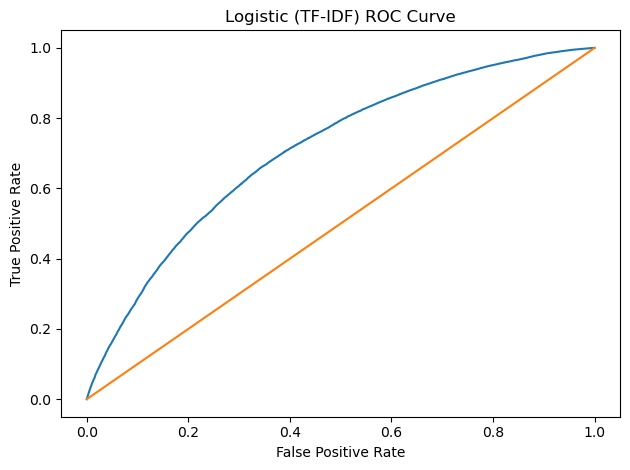

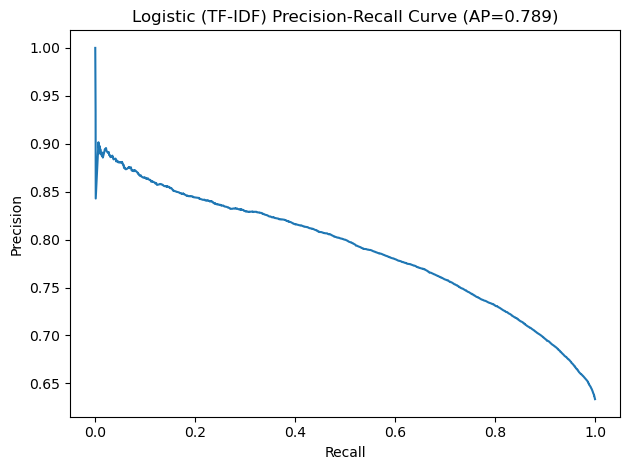

KNN Confusion Matrix:
 [[14966 21682]
 [10479 52873]]

KNN Report:
               precision    recall  f1-score   support

           0       0.59      0.41      0.48     36648
           1       0.71      0.83      0.77     63352

    accuracy                           0.68    100000
   macro avg       0.65      0.62      0.62    100000
weighted avg       0.66      0.68      0.66    100000



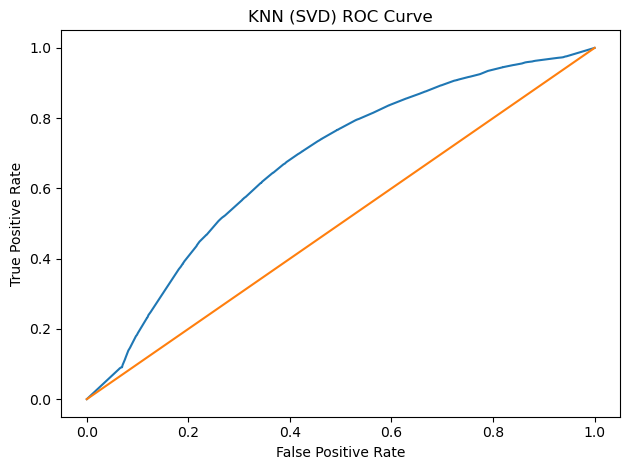

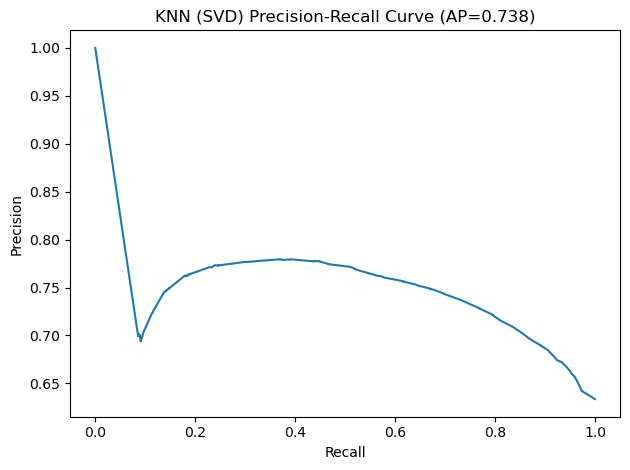

RF Confusion Matrix:
 [[15004 21644]
 [ 9415 53937]]

RF Report:
               precision    recall  f1-score   support

           0       0.61      0.41      0.49     36648
           1       0.71      0.85      0.78     63352

    accuracy                           0.69    100000
   macro avg       0.66      0.63      0.63    100000
weighted avg       0.68      0.69      0.67    100000



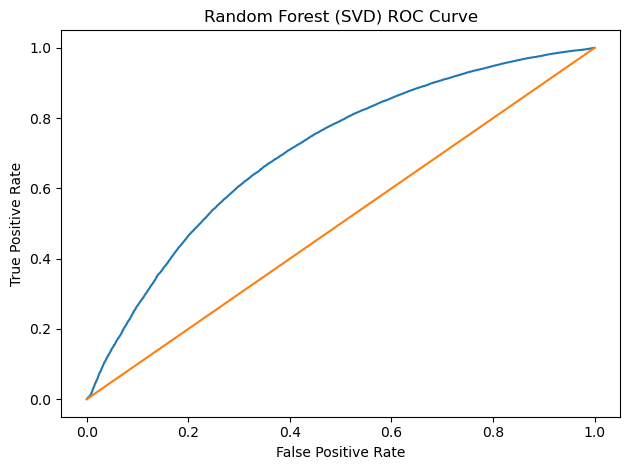

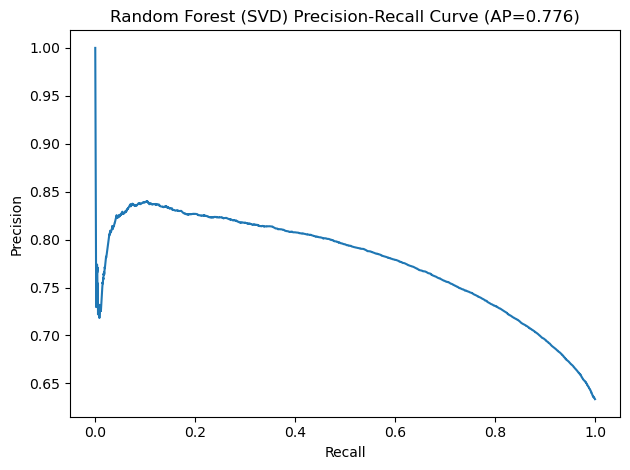

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic (TF-IDF),0.69048,0.711306,0.860794,0.778943,0.711185
2,Random Forest (SVD),0.68941,0.713632,0.851386,0.776446,0.705554
1,KNN (SVD),0.67839,0.709181,0.834591,0.766792,0.674183


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

bin_results = []

# Logistic Regression on TF-IDF
log_clf = LogisticRegression(max_iter=400)
log_clf.fit(Xb_train, yb_train)

log_score = log_clf.predict_proba(Xb_test)[:, 1]
log_pred  = (log_score >= 0.5).astype(int)

metrics_log = binary_metrics(yb_test, log_pred, log_score)
bin_results.append({"Model": "Logistic (TF-IDF)", **metrics_log})

print("Logistic Confusion Matrix:\n", confusion_matrix(yb_test, log_pred))
print("\nLogistic Report:\n", classification_report(yb_test, log_pred, zero_division=0))
plot_roc_pr(yb_test, log_score, "Logistic (TF-IDF)")

# KNN Classifier on SVD
knn_clf = KNeighborsClassifier(n_neighbors=35, weights="distance")
knn_clf.fit(Xb_train_svd, yb_train)

knn_score = knn_clf.predict_proba(Xb_test_svd)[:, 1]
knn_pred  = (knn_score >= 0.5).astype(int)

metrics_knn = binary_metrics(yb_test, knn_pred, knn_score)
bin_results.append({"Model": "KNN (SVD)", **metrics_knn})

print("KNN Confusion Matrix:\n", confusion_matrix(yb_test, knn_pred))
print("\nKNN Report:\n", classification_report(yb_test, knn_pred, zero_division=0))
plot_roc_pr(yb_test, knn_score, "KNN (SVD)")

# Random Forest Classifier on SVD
rf_clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(Xb_train_svd, yb_train)

rf_score = rf_clf.predict_proba(Xb_test_svd)[:, 1]
rf_pred  = (rf_score >= 0.5).astype(int)

metrics_rf = binary_metrics(yb_test, rf_pred, rf_score)
bin_results.append({"Model": "Random Forest (SVD)", **metrics_rf})

print("RF Confusion Matrix:\n", confusion_matrix(yb_test, rf_pred))
print("\nRF Report:\n", classification_report(yb_test, rf_pred, zero_division=0))
plot_roc_pr(yb_test, rf_score, "Random Forest (SVD)")

bin_table = pd.DataFrame(bin_results).sort_values("ROC_AUC", ascending=False)
bin_table


## Cross-Validation (More Robust Evidence)

A single train/test split is useful, but cross-validation is stronger evidence for model comparison.

This section runs cross-validation on reduced features for speed. If it runs slowly on your laptop, reduce the sample size.


In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Sample for CV to keep it practical
n_cv = min(600_000, X.shape[0])
idx = np.random.RandomState(42).choice(np.arange(X.shape[0]), size=n_cv, replace=False)

X_cv = X[idx]
y_cv = y[idx]

# Regression CV on Ridge (TF-IDF)
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

ridge_cv = Ridge(alpha=1.0)
rmse_scores = cross_val_score(ridge_cv, X_cv, y_cv, cv=cv, scoring=rmse_scorer)

print("Ridge CV RMSE (negative scores):", rmse_scores)
print("Ridge CV RMSE (mean):", -rmse_scores.mean())


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge CV RMSE (negative scores): [-0.97564366 -0.97442772 -0.97702383]
Ridge CV RMSE (mean): 0.9756984030187282


c:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Final Summary Tables

These tables are report-ready. They show which regression model best predicts ratings and which binary model best predicts thumbs-up.


In [16]:
reg_table.reset_index(drop=True), bin_table.reset_index(drop=True)


(                           Model      RMSE       MAE        R2
 0                 Ridge (TF-IDF)  0.974163  0.752612  0.159120
 1  Random Forest Regressor (SVD)  0.980384  0.756384  0.148346
 2                 Lasso (TF-IDF)  1.007900  0.788944  0.099869
 3            KNN Regressor (SVD)  1.030980  0.795307  0.058173,
                  Model  Accuracy  Precision    Recall        F1   ROC_AUC
 0    Logistic (TF-IDF)   0.69048   0.711306  0.860794  0.778943  0.711185
 1  Random Forest (SVD)   0.68941   0.713632  0.851386  0.776446  0.705554
 2            KNN (SVD)   0.67839   0.709181  0.834591  0.766792  0.674183)

In [18]:

import pickle
import os


os.makedirs('models', exist_ok=True)

print("\n1/8 Saving TF-IDF vectorizer...")
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("   ✓ TF-IDF saved")

# 2. Save movie features matrix
print("\n2/8 Saving movie features...")
with open('models/X_movies_tfidf.pkl', 'wb') as f:
    pickle.dump(X_movies, f)
print("   ✓ Movie features saved")

# 3. Save movie ID mapping
print("\n3/8 Saving movie ID mapping...")
with open('models/movie_id_to_index.pkl', 'wb') as f:
    pickle.dump(movie_id_to_index, f)
print("   ✓ Movie mapping saved")

# 4. Save movies dataframe with content
print("\n4/8 Saving movies dataframe...")
with open('models/movies_cb.pkl', 'wb') as f:
    pickle.dump(movies_cb, f)
print("   ✓ Movies dataframe saved")

# 5. Save best regression model (Ridge)
print("\n5/8 Saving Ridge model...")
with open('models/ridge_model.pkl', 'wb') as f:
    pickle.dump(ridge, f)
print("   ✓ Ridge model saved")

# 6. Save best classifier (Random Forest)
print("\n6/8 Saving Random Forest classifier...")
with open('models/rf_classifier.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)
print("   ✓ Random Forest saved")

# 7. Save SVD transformer
print("\n7/8 Saving SVD transformer...")
with open('models/svd_transformer.pkl', 'wb') as f:
    pickle.dump(svd, f)
print("    SVD saved")

# 8. Save weighted popularity results
print("\n8/8 Saving top movies...")
with open('models/top_movies.pkl', 'wb') as f:
    pickle.dump(top_movies, f)
print("    Top movies saved")


import os
full_path = os.path.abspath('models')
print(f"\n Files saved to: {full_path}")
print("\nSaved files:")
for file in os.listdir('models'):
    size = os.path.getsize(f'models/{file}') / (1024*1024)  # MB
    print(f"    {file} ({size:.1f} MB)")

print("\n" + "="*60)


1/8 Saving TF-IDF vectorizer...
   ✓ TF-IDF saved

2/8 Saving movie features...
   ✓ Movie features saved

3/8 Saving movie ID mapping...
   ✓ Movie mapping saved

4/8 Saving movies dataframe...
   ✓ Movies dataframe saved

5/8 Saving Ridge model...
   ✓ Ridge model saved

6/8 Saving Random Forest classifier...
   ✓ Random Forest saved

7/8 Saving SVD transformer...
    SVD saved

8/8 Saving top movies...
    Top movies saved

 Files saved to: c:\Users\Aisha N Chihuri\Downloads\final_ml_group_project\ml-latest\models

Saved files:
    movies_cb.pkl (49.3 MB)
    movie_id_to_index.pkl (0.1 MB)
    rf_classifier.pkl (670.1 MB)
    ridge_model.pkl (0.2 MB)
    svd_transformer.pkl (45.8 MB)
    tfidf_vectorizer.pkl (0.6 MB)
    top_movies.pkl (0.0 MB)
    X_movies_tfidf.pkl (12.8 MB)

